In [2]:
import sys
print(sys.version_info)
assert sys.version_info >= (3, 7)

from packaging import version
import sklearn
print ("Scikit-Learn version: ", sklearn.__version__)
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

sys.version_info(major=3, minor=11, micro=4, releaselevel='final', serial=0)
Scikit-Learn version:  1.3.0


here we're trying to get the wrong labeled data (like "=" is labeled to "+")
BUT it is impossible to check all 17000 img and check them(we can, but... really?)
or we can use the model to identify them

how? by using well-trained model! we have Mnist!
so the plan is;
1. train the mnist that has a good score(like 0.97 or 98)
2. for each img check the score using our mnist model. If the score is quite low(to a certain threshold, we may assume that is it mislabeled
3. check the img and label, and fix

this may minimize our man-work

In [3]:
from pathlib import Path

path = Path() / "npz" / "asdf"
print(path)

npz\asdf


## dataset preparation

In [9]:
from sklearn.datasets import fetch_openml

openml = fetch_openml('mnist_784', as_frame=False, parser="auto")
mnist = openml

# get the latest datasets
curr_data_num_trVal = np.load(path / "digit_data_TrVal_corrected.npz")
curr_data_sym_trVal = np.load(path / "op_data_TrVal_corrected.npz")

curr_data_num_test = np.load(path / "digit_data_10_Test_corrected.npz")
curr_data_sym_test = np.load(path / "op_data_10_Test_corrected.npz")

## prepare models

currently, our strongest model so far is the assemble model, with 0.97 score

### mnist

In [27]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(random_state=42))
    ]
,voting="soft",n_jobs=-1)
X_train, y_train = mnist.data, mnist.target
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))],
                 n_jobs=-1, voting='soft')

In [35]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

random = 42

# StandardScaler 사용
nn_clf_mnist = make_pipeline(StandardScaler(), MLPClassifier(random_state=random,solver="lbfgs",max_iter=300))
X_train, y_train = mnist.data, mnist.target
nn_clf_mnist.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(max_iter=300, random_state=42, solver='lbfgs'))])

In [36]:
from sklearn.model_selection import cross_val_score

cross_val_score(nn_clf_mnist, X_train, y_train, cv=5)

KeyboardInterrupt: 

### our data

In [10]:
def rebase_center(img):
    r = 28
    c = 28

    # each boundary
    r_top = r
    r_bot = -1
    c_left = c
    c_right = -1

    for n in range(r):
        for m in range(c):
            
            # if the pixel has whatever value
            if img[n][m] != 0:
                # update the boundary
                r_top = min(r_top, n)
                r_bot = max(r_bot, n)
                c_left = min(c_left, m)
                c_right = max(c_right, m)
    
    # print(r_top,r_bot,c_left,c_right)
    
    c_len = c_right - c_left + 1
    r_len = r_bot - r_top + 1

    c_start = int((c - c_len) / 2)
    r_start = int((r - r_len) / 2)

    # print(c_len,r_len,c_start,r_start)

    rebased_data = np.zeros((r,c),dtype="float64")

    # rebase into a center
    rebased_data[r_start:r_start+r_len, c_start:c_start+c_len] = img[r_top:r_bot+1, c_left:c_right+1]
    
    return rebased_data


In [11]:
def detect_del_boundary(img, thickness=4, threshold=10):
    curr = np.reshape(img, (28, 28))

    # how much you want to look at
    t = thickness
    # the threshold
    threshold_t = threshold

    cnt_top = np.count_nonzero(curr[0:t, :])
    cnt_down = np.count_nonzero(curr[28 - t:28, :])
    cnt_left = np.count_nonzero(curr[:, 0:t])
    cnt_right = np.count_nonzero(curr[:, 28 - t:28])

    flag = False

    if cnt_top > threshold_t:
        curr[0:t, :] = 0.
        flag = True

    if cnt_down > threshold_t:
        curr[28 - t:28, :] = 0.
        flag = True

    if cnt_left > threshold_t:
        curr[:, 0:t] = 0.
        flag = True

    if cnt_right > threshold_t:
        curr[:, 28 - t:28] = 0.
        flag = True

    return rebase_center(curr) if flag is True else curr


In [12]:
def preprocessing(img, rebase=True, b_del=True, thick=True, one_array=True):    
    size = np.shape(img)[0]
    
    # row and column length
    r = 28
    c = 28
    
    # reshape to 2-d array(for convenience)
    img_preprocessed = np.reshape(img,(size,r,c))
    
    # rebase
    if rebase:
        print("rebase ongoing")
        
        for x in range(size):
            img_preprocessed[x] = rebase_center(img_preprocessed[x])
        print("done!")
    
    # border deletion
    if b_del:
        print("border deletion ongoing")
        
        for x in range(size):
            img_preprocessed[x] = detect_del_boundary(img_preprocessed[x])
            
        print("done!")
    
    # thickening
    if thick:
        print("thickening ongoing")
        
        print("done!")
    
    return np.reshape(img_preprocessed,(size,r*c)) if one_array else np.reshape(img_preprocessed,(size,r,c))


In [ ]:
# RobustScaler 사용
nn_clf_ours = make_pipeline(RobustScaler(), MLPClassifier(random_state=random,solver="lbfgs",max_iter=300))
X_train_ours, y_train_ours = preprocessing(curr_data_num_trVal["img"].copy()), curr_data_num_trVal["label"].copy()

nn_clf_ours.fit(X_train_ours, y_train_ours)

In [ ]:
cross_val_score(nn_clf_ours, X_train_ours, y_train_ours, cv=5)

so now we have 2 models, mnist and ours with 0.97, 0.80 score

### find mislabel - test

In [8]:
# size = np.shape(X_train_our)[0]
# 
# for i in range(size):
#     curr = X_train_our[i]
#     label = curr_data_sym_trVal["label"][i]
#
#     predict_mnist = voting_clf.predict(curr)
#     predict_ours = voting_clf_ours.predict(curr)
#     
#     score_mnist = voting_clf.score(curr)
#     score_ours = voting_clf_ours.score(curr)


SyntaxError: incomplete input (2525210768.py, line 3)

In [31]:
curr = np.reshape(X_train_our[10], (1,-1))

predict_mnist = voting_clf.predict(curr)
predict_ours = voting_clf_ours.predict(curr)

print(predict_mnist, predict_ours)

# score_mnist = voting_clf.predict_proba(curr)
# score_ours = voting_clf_ours.predict_proba(curr)

AttributeError: predict_proba is not available when  probability=False

In [17]:
import matplotlib.pyplot as plt

def plot_digit(image_data, axis=False):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")

    if not axis:
        plt.axis("off")

(784,)

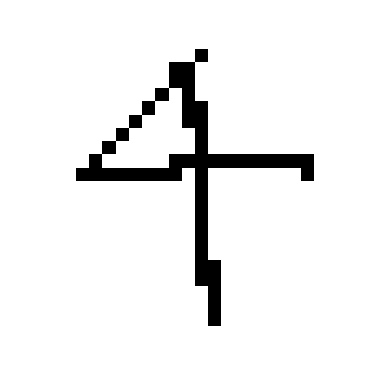

In [19]:
plot_digit(curr)
np.shape(curr)

In [22]:
test = np.reshape(curr, (1,-1))

In [23]:
test

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [28]:
i = '3'
'3' == i

True